In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

### Load model

In [2]:
from in_silico.model.mlflow_loader import ModelPaths, DataPaths, load_free_viewing_model_from_mlflow

model_paths = ModelPaths(
    checkpoint_uri="mlflow-artifacts:/621818231566971674/2f85fd6f5dda46e280456d3186618e1c/artifacts/6806be20120f307fa684cd4c637ad949_final.pth.tar",
    config_uri="mlflow-artifacts:/621818231566971674/2f85fd6f5dda46e280456d3186618e1c/artifacts/6806be20120f307fa684cd4c637ad949_final_cfg.pth.tar",
)
data_paths = DataPaths(session_dirs=["/mnt/data1/enigma/goliath_10_20_sandbox/37_3843837605846_0_V3A_V4/"])

out = load_free_viewing_model_from_mlflow(
    model_paths,
    data_paths,
    cuda_visible_devices="9",
    mlflow_tracking_uri="https://mlflow.enigmatic.stanford.edu/",
    mlflow_username="mlflow-runner",
    mlflow_password="x3i#U9*73N75",
)

Skipping import of cpp extensions due to incompatible torch version 2.7.0a0+7c8ec84dab.nv25.03 for torchao version 0.16.0             Please see https://github.com/pytorch/ao/issues/2919 for more info


/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Dataset 0: 37_3843837605846_0_V3A_V4, length = 215312
Sessions: ['37_3843837605846_0_V3A_V4']
Batches per session: {'37_3843837605846_0_V3A_V4': 26914}
Total batches: 26914
Created FastSessionDataLoader with 1 sessions and 26914 total batches
Dataset 0: 37_3843837605846_0_V3A_V4, length = 22977
Sessions: ['37_3843837605846_0_V3A_V4']
Batches per session: {'37_3843837605846_0_V3A_V4': 2872}
Total batches: 2872
Created FastSessionDataLoader with 1 sessions and 2872 total batches


In [3]:
from in_silico.model.wrapper import ModelWrapper

# out is the tuple returned by load_free_viewing_model_from_mlflow(...)
model, skip_samples, cfg, extra = out   # <-- now cfg exists

# pick skip_samples: prefer the returned value if it exists
# (some codebases return it explicitly, and cfg may or may not have it)
if skip_samples is None:
    skip_samples = cfg.trainer.skip_n_samples

wrapper = ModelWrapper(model, skip_samples=skip_samples)

### Load indices

In [4]:
indices_v3a = np.load('/workdir/analysis_parametric/indices_v3a.npy')

### Create stimulus

In [5]:
from in_silico.stimuli.sparse_noise import SparseNoiseSpec, make_sparse_noise

In [9]:
spec = SparseNoiseSpec(
    num_samples=12,
    dot_offset_samples=3,
    dot_duration_samples=6,
    fps=30.0,
    square_size_px = 25,
    dots_per_frame = 100,
    seed= 61
)

frames, ts, events = make_sparse_noise(spec)

In [10]:
frames.shape

(12, 3, 236, 420)

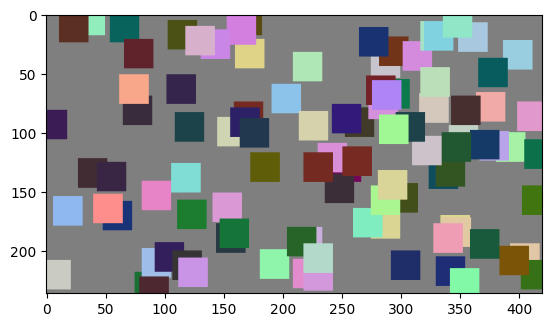

In [11]:
plt.imshow(frames[5].transpose((1,2,0)))

### Predict responses

In [12]:
from in_silico.analyses.dotmapping import predict_responses, compute_sta, sta_to_rgb
import numpy as np

# 1. Generate stimuli + collect predictions
frames_all, pred_all, avg_resp_all, seeds = predict_responses(
    wrapper,
    key="37_3843837605846_0_V3A_V4",
    N=5000,
    square_size_px=25,
    dots_per_frame=100,
    ds_factor=4,
)
# frames_all → (N, T, C, H_ds, W_ds)
# pred_all   → (N, U, T_pred)

Predicting responses:   0%|          | 0/5000 [00:00<?, ?stim/s]

In [13]:
# 2. Compute and save the spatial STA
sta, denom, stim_mean = compute_sta(
    frames_all, pred_all,
    t_frame=5,
    zscore_normalize=True,
)
np.save("/mnt/lab/users/Katrin/monkey_dynamic/dotmapping_spatial/sta_spatial.npy", sta)
# sta → (U, C, H, W)

Computing STA:   0%|          | 0/653 [00:00<?, ?neuron/s]

(-0.5, 104.5, 58.5, -0.5)

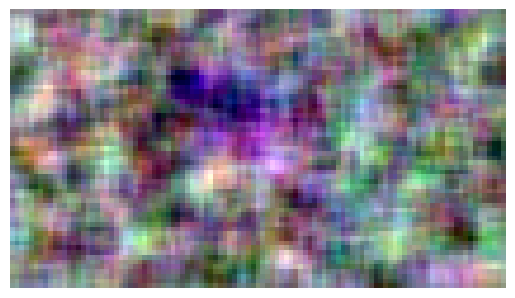

In [18]:
# 3. Visualise
rgb = sta_to_rgb(sta[4], mode="robust", p=99.5)
plt.imshow(rgb); plt.axis("off")

In [19]:
pred_all

(5000, 653, 9)

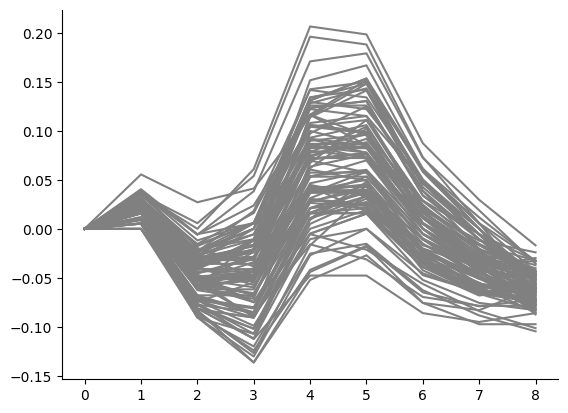

In [24]:
plt.plot(pred_all[np.random.choice(4999, 100),0,:].T, color = 'gray')
sns.despine()